# Construire et entraîner un processus gaussien via l'objet _class_ de python

L'objectif de ce TP est double :
- apprendre un modèle de processus gaussien à partir de données (régression)
- se familiariser avec l'objet ```class``` de python

Voir https://courspython.com/classes-et-objets.html pour une introduction aux classes.

Version originale : Felipe Tobar, Adapté pour IATI par Elsa Cazelles

#### Le processus gaussien

Dans ce TP, nous considèrerons un noyau de mélange spectral, défini pour deux vecteurs de même taille $x$ et $x'$, et trois paramètres $\gamma, \mu$ et $\sigma$, par:

$$\text{Spec_Mix}(x, x', \gamma, \mu, \sigma) = \sigma^2 * \exp(-\gamma \Vert x-x'\Vert^2)\cos(2\pi\mu\Vert x-x'\Vert).$$

Le modèle de régression considéré est alors le suivant:

$$y \sim \mathcal{GP}(0,K),$$
avec
$$K(x,x') = \text{Spec_Mix}(x, x', \gamma, \mu, \sigma) + \sigma^2_{\text{noise}}\text{Id}.$$

**Exercice :** Le vecteur de paramètres est donc donné par

$$\theta = (\gamma, \mu, \sigma, \sigma^2_{\text{noise}}).$$

Commençons par importer les modules nécessaires.

In [1]:
# Bibliothèques pour les calculs mathématiques et pour l'affichage des courbes
import numpy as np
import matplotlib.pyplot as plt


On commence par créer un fichier **outils.py**, dans lequel on définit le noyau **Spec_Mix($\boldsymbol{x}_1, \boldsymbol{x}_2, \gamma, \mu, \sigma$)**.


**Remarque :** le noyau **Spec_Mix** prend en entrée des **vecteurs** $\boldsymbol{x}_1$ et $\boldsymbol{x}_2$, et renvoie une matrice $M$ avec pour entrées $M_{ij} = \text{Spec_Mix}(x_1^{i}, x_2^{j}, \gamma, \mu, \sigma)$. On évitera d'utiliser des boucles pour construire la matrice $M$, on utilisera plutôt la fonction ```np.outer```.

In [2]:
# Test du noyau Spec_Mix
from outils import Spec_Mix

x1 = np.array([1,2,3])
Spec_Mix_Test = Spec_Mix(x1,x1,1,1,1)

print(Spec_Mix_Test)

[[1.         0.36787944 0.01831564]
 [0.36787944 1.         0.36787944]
 [0.01831564 0.36787944 1.        ]]


Nous allons maintenant construire la classe **gp_class**, au fur et à mesure du TP, en y ajoutant des fonctions. En premier lieu, importer la classe en l'appelant dans la variable **gp**.

In [3]:
from gp_class import *

# Importation de la classe et initialisation des hyperparamètres
gp = gp_class()
gp.init_hypers()



Regarder comment se présente la fonction classe dans **gp_class.py**, ainsi que les variables enregistrées dans la classe.

Nous allons construire la fonction ```calcul_posterieur```, qui renvoie la moyenne et la covariance du GP a posteriori.
- Dans un premier temps, nous n'avons aucune données, la moyenne est considérée nulle, et la covariance du GP est tirée selon une grille ```time``` pré-définie. Nous pouvons toujours générer plusieurs trajectoires du processus gaussien.
- Dans un second temps, nous avons accès à des données, et la moyenne et la covariance du GP a posteriori dépendront de ces données ```where```.


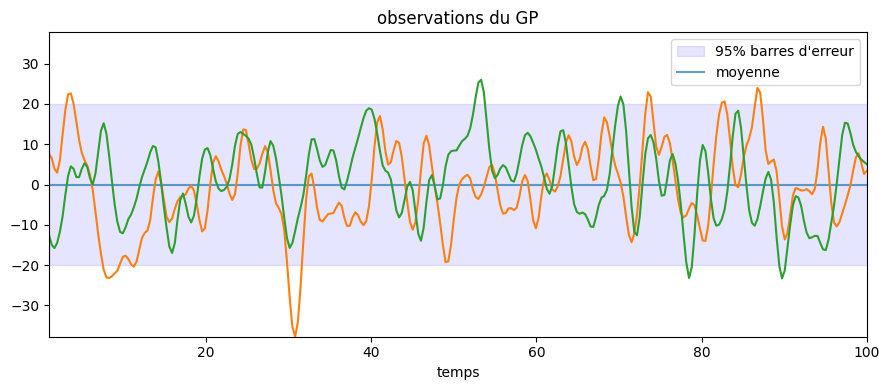

In [4]:
# Calcul du Processus Gaussien à posteriori
gp.compute_posterior(dimension=300)

# Génération d'échantillons
N_samples = 2
echantillons = gp.sample(N_samples)

# Affichage des échantillons
gp.plot_samples()


#### Donnons nous maintenant des observations.

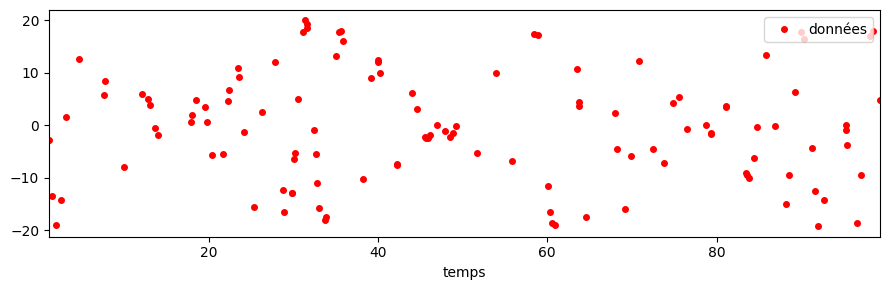

In [5]:
# Produire les données
N = 120
x = 100*np.random.random(N) + 0.1*np.random.randn(N)
y = 20*np.cos(1.5*x)*np.cos(0.1*x) + 0.1*np.random.randn(N)

# Chargement des données dans la classe gp
gp.load(x,y)

# Affichage des données sur un graphique
gp.plot_data()

**Exercice :** Calculer de nouveau le GP a posteriori à partir des données $x$ et $y$. Ensuite générer et tracer 5 trajectoires de processus gaussien correspondant à ces données.

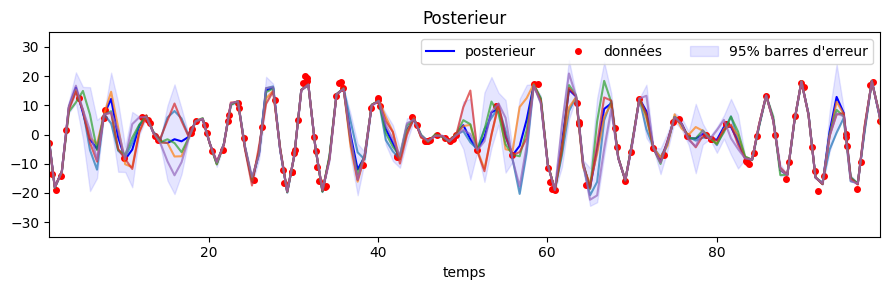

In [6]:
# Calcul du nouveau GP à postériori
gp.compute_posterior(dimension=N)

# Génération et affichage de 5 trajectoires
gp.plot_posterior(n_samples=5)


## Entraînement des hyper-paramètres du processus gaussien

Pour cela, nous allons utiliser la fonction ```minimize```de ```scipy.optimize```, qui optimisera les hyper-paramètres par descente de gradient. Nous allons donc définir deux fonctions dans la classe gp:
- la fonction de la log-vraisemblance négative ```nlogp```, très proche de ```nll```mais qui prend en entrée les hyperparamètres à optimiser:


**Remarque :** Ici nous effectuons un changement de variables pour les paramètres : en considérant des exponentielles, on s'assure que les paramètres sont strictement positifs.

- la fonction qui retourne le gradient de ```nlogp``` en fonction des hyperparamètres



In [7]:
# Apprentissage des hyperparamètres
gp.train()

#Affichage des hyperparamètres
gp.show_hypers()

gamma: 0.0007854868613785934, i.e., lengthscale = 25.229900606436143
sigma: 27.12925402436045
sigma_n: 0.10084728691148034
mu: 0.23843510619234787


**Exercice :** On peut de nouveau calculer le postérieur et l'évaluer (plot) en de nouveaux points.

/content/gp_class.py:34: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(self.mean, self.cov, size=how_many)


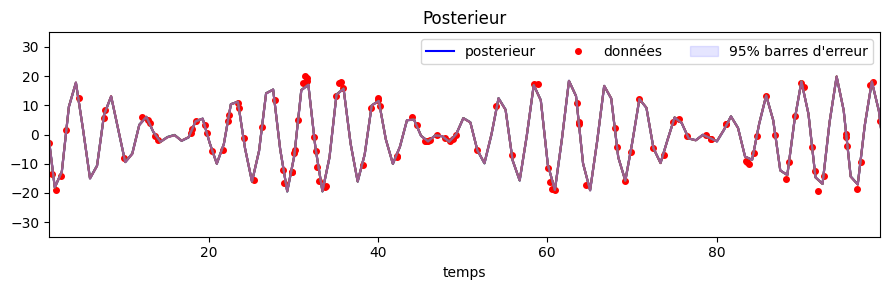

In [8]:
# Calcul du nouveau GP à postériori
gp.compute_posterior(dimension=N)

# Génération et affichage de 5 trajectoires
gp.plot_posterior(n_samples=5)

On remarque également que la log-vraisemblance négative est minimisée après entraînement:

In [9]:
print(f'negative log-likelihood: {gp.nll()}')

negative log-likelihood: -16.099117762844458


## Exemple sur un jeu de données réelles : fréquence cardiaque

In [10]:
# Chargement et préparation des données

import statsmodels.api as sm

signal = np.loadtxt('hr1.txt')
time = (np.linspace(0, 1800,1800))
time_label = 'Temps'
signal_label = 'Fréquence cardiaque'

# On centre le signal
signal = signal - np.mean(signal)

# on choisit un nombre d'observations sur les 1800 disponibles
N_obs = 400
indices = np.arange(len(signal))
np.random.shuffle(indices)
indices = indices[:N_obs]
indices = np.sort(indices)
signal_init = signal[indices]
time_init = time[indices]


#### Effectuer la même analyse que précédemment sur ce jeu de données, en précisant les étapes.

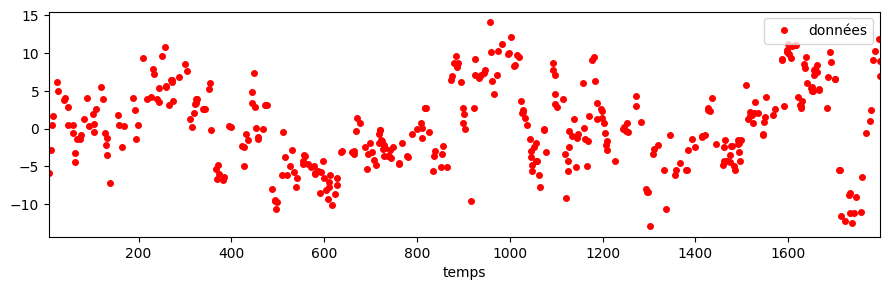

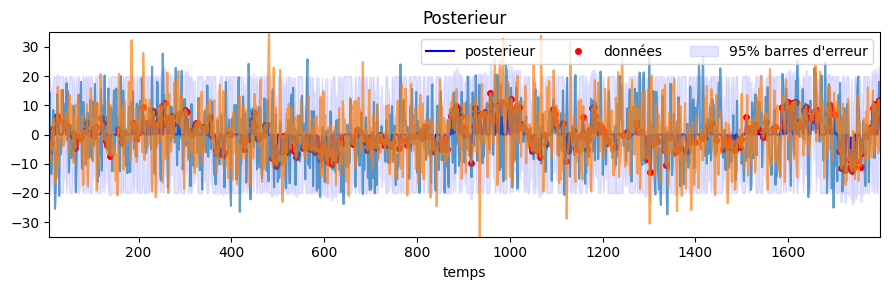

In [11]:
# Importation des données
gp = gp_class()
# Initialisation des hyper-paramètres
gp.init_hypers()
# Importation des données
gp.load(time_init, signal_init)
# Affichage des données
gp.plot_data()
# Calcul du nouveau GP à postériori
gp.compute_posterior(dimension=N_obs, where=time)
# Génération et affichage de 2 trajectoires
gp.plot_posterior(n_samples=2)


gamma: 0.015948294891258877, i.e., lengthscale = 5.5992244055350415
sigma: 5.1319721486853105
sigma_n: 0.7856902605253979
mu: 0.0005310949785137837


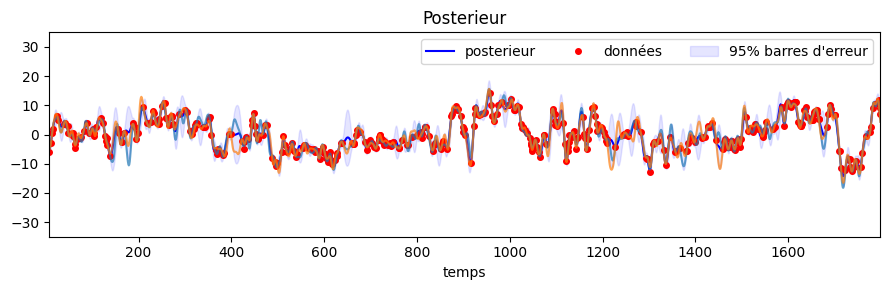

In [12]:
# Entraînement du modèle
gp.train()
# Affichage des hyper-paramètres
gp.show_hypers()
# Calcul du nouveau GP à postériori
gp.compute_posterior(dimension=N_obs, where=time)
# Génération et affichage de 2 trajectoires
gp.plot_posterior(n_samples=2)

## Exercice supplémentaire : Utiliser pytorch et la différentiation automatique pour résoudre le problème d'optimisation

Itération 1/500 - Loss: 1321.3601
Itération 50/500 - Loss: 1178.7681
Itération 100/500 - Loss: 1139.7922
Itération 150/500 - Loss: 1137.7007
Itération 200/500 - Loss: 1114.3995
Itération 250/500 - Loss: 1054.6189
Itération 300/500 - Loss: 1023.3000
Itération 350/500 - Loss: 1012.2258
Itération 400/500 - Loss: 1007.3046
Itération 450/500 - Loss: 1005.1989
Itération 500/500 - Loss: 1004.7719

Nouveaux Hyperparamètres : 

gamma: 0.012983452119472681, i.e., lengthscale = 6.2056876401399315
sigma: 4.792121279898786
sigma_n: 1.4156070970964452
mu: 0.007093832120597026


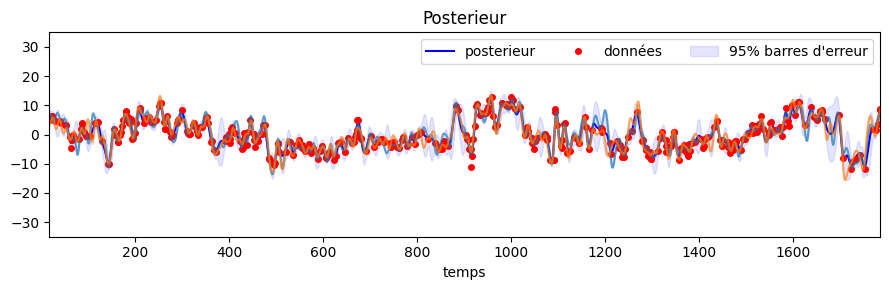

In [24]:
# Chargement et préparation des données (PyTorch)

import statsmodels.api as sm
import torch

signal = np.loadtxt('hr1.txt')
time = (np.linspace(0, 1800,1800))
time_label = 'Temps'
signal_label = 'Fréquence cardiaque'

# On centre le signal
signal = signal - np.mean(signal)

# On choisit un nombre d'observations sur les 1800 disponibles
N_obs = 400
indices = np.arange(len(signal))
np.random.shuffle(indices)
indices = indices[:N_obs]
indices = np.sort(indices)
signal_init = signal[indices]
time_init = time[indices]

# Initialisation des Hyperparamètres
gp = gp_class()
gp.init_hypers()

# Importation des données
gp.load(time_init, signal_init)

# Hyperparamètres à optimiser (on travaille dans l'espace log)
log_sigma = torch.tensor(np.log(gp.sigma), dtype=torch.float64, requires_grad=True)
log_gamma = torch.tensor(np.log(gp.gamma), dtype=torch.float64, requires_grad=True)
log_mu = torch.tensor(np.log(gp.mu), dtype=torch.float64, requires_grad=True)
log_sigma_noise = torch.tensor(np.log(gp.sigma_n), dtype=torch.float64, requires_grad=True)

# Configuration de l'optimiseur
optim = torch.optim.Adam([log_sigma, log_gamma, log_mu, log_sigma_noise], lr=0.01)

# Boucle d'optimisation
n_iterations = 500

for i in range(n_iterations):
    # Remise à zéro des gradients
    optim.zero_grad()

    # Calcul de la perte
    loss = gp.nlogp_v2([log_sigma, log_gamma, log_mu, log_sigma_noise])

    # Rétropropagation
    loss.backward()

    # Mise à jour des paramètres
    optim.step()

    # Affichage périodique
    if (i + 1) % 50 == 0 or i == 0:
        print(f"Itération {i+1}/{n_iterations} - Loss: {loss.item():.4f}")


# Mise à jour des hyperparamètres dans l'objet gp
gp.sigma = np.exp(log_sigma.detach().numpy())
gp.gamma = np.exp(log_gamma.detach().numpy())
gp.mu = np.exp(log_mu.detach().numpy())
gp.sigma_n = np.exp(log_sigma_noise.detach().numpy())


# Affichage des hyper-paramètres
print('\nNouveaux Hyperparamètres : \n')
gp.show_hypers()

# Calcul du nouveau GP à postériori
gp.compute_posterior(dimension=N_obs, where=time)

# Génération et affichage de 2 trajectoires
gp.plot_posterior(n_samples=2)